In [5]:
#importing modules 
import json 
import pandas as pd
import numpy as np
import csv
from fuzzywuzzy import fuzz, process
import re
from timeit import default_timer as timer
import random
import matplotlib.pyplot as plt

# test file path
path = "./test_directory_files/"
tsv = "tsv/"
locations = "4b119360-317a-0134-9131-00505686a51c_locations.tsv"
occupations = "4b119360-317a-0134-9131-00505686a51c_occupations.tsv"
subjects = "4b119360-317a-0134-9131-00505686a51c_subjects.tsv"
test_json = "119.56837603.5abc93e0-6e04-0134-173e-00505686a51c_labeled.json"
street_names_txt = "./city-directory-entry-parser-master/streetnames.txt"

# set seed
random.seed(160220)

In [278]:
# Open tsvs and streetnames
## From Nick: Columns are the directory uuid, page uuid, entry uuid, the number (in 0,1,2,3 index order) of the entry 
##            (remember that there could be more than one subject per entry, more than one occupation, etc.).Most are 
##            entry 0, but sometimes you might find an entry 1 if there are multiple subjects/occupations/locations. 
##            Then an offset number, e.g. the order of the token from the start of the entry. So a 0th token, 1st token,
##            2nd token, etc. And finally the token itself in the last column.
##            Remember that we have to keep that entry and offset number linked to each token otherwise we won't be able 
##            to swap any corrections back into the JSON file once we have a listed of recommended edits.

locations_tsv = pd.read_csv(path + tsv + locations, 
                           sep = "\t",
                           quoting = csv.QUOTE_NONE)
occupations_tsv = pd.read_csv(path + tsv + occupations, 
                           sep = "\t",
                           quoting = csv.QUOTE_NONE)
subjects_tsv = pd.read_csv(path + tsv + subjects, 
                           sep = "\t",
                           quoting = csv.QUOTE_NONE)
master_street_names = pd.read_csv(street_names_txt, 
                                  header = None)
master_street_names = master_street_names[0].tolist()
#master_street_names

In [151]:
print(locations_tsv.entry_uuid.nunique())
#locations_tsv.head(n = 20)

164451


In [152]:
# function remove punctuation and default to lowercase
def clean_token(token):
    token_lower = token.lower()
    token_clean = ''.join(t for t in token_lower if t.isalnum())
    return token_clean

# apply to column and create new column
locations_tsv["token_re"] = locations_tsv["token"].apply(clean_token)

# drop rows with just whitespace
locations_tsv = locations_tsv.drop(locations_tsv[(locations_tsv.token_re == '')].index)

# create trial pd
locations_tsv_trunc = locations_tsv.sample(n = 100)
#locations_tsv_trunc.head(n=50)

In [153]:
#start = timer()

# Create lists for similar and dissimilar tokens
tesseract_s = []
pct_similarity_s = []
best_guess_s = []
tesseract_d = []
pct_similarity_d = []
best_guess_d = []
def fuzzy_match(x, choices=master_street_names, scorer=fuzz.token_sort_ratio, 
                tesseract_s = tesseract_s, pct_similarity_s = pct_similarity_s, best_guess_s = best_guess_s,
                tesseract_d = tesseract_d, pct_similarity_d = pct_similarity_d, best_guess_d = best_guess_d):
    n = 0
    # check if numeric:
    digit_check = x.isdigit()
    if digit_check is True:
        return x
    else:
        best_guess, pct_similarity = process.extractOne(x, choices=choices, scorer=scorer)
        if pct_similarity >= 90:
            tesseract_s.append(x)
            pct_similarity_s.append(pct_similarity)
            best_guess_s.append(best_guess)
            return best_guess
        else:
            tesseract_d.append(x)
            pct_similarity_d.append(pct_similarity)
            best_guess_d.append(best_guess)
            return None
            
        #print(best_guess)
        #print(pct_similarity)

# create a second truncated df to trial
locations_tsv_trunc_2 = locations_tsv_trunc
    
# Following post explains why token_sort_ratio might be best 
## https://medium.com/analytics-vidhya/matching-messy-pandas-columns-with-fuzzywuzzy-4adda6c7994f
## tldr: converts each word to a token, then sorts aphabetically. 
## Streetnames that are abbrievated and in full both start with the same letter so this avoids errors like bway -> w  
locations_tsv["token_replaced"] = locations_tsv["token_re"].apply(
    fuzzy_match
#    ,args=(
#        master_street_names,
#        fuzz.token_sort_ratio
#    )
)
 
#end = timer()
#print(end - start)

In [163]:
# Put the lists from replacement fn above into a df
## Dissimilarity
dissimilar_frequency_df = pd.DataFrame({"Tesseract": tesseract_d,
                    "Guess": best_guess_d,
                    "Similarity": pct_similarity_d}) 
## Similarity
similar_frequency_df = pd.DataFrame({"Tesseract": tesseract_s,
                    "Guess": best_guess_s,
                    "Similarity": pct_similarity_s}) 

**Objectives:**  
1) Find common Tesseract tokens  
2) Assign level of confidence  
3) Swap out those with high level of confidence  

In [172]:
similar_frequency_df

,Tesseract,Guess,Similarity
0,elm,Elm,100
1,madison,Madison,100
2,seventh,Seventh,100
3,av,Av,100
4,first,First,100
...,...,...,...
238086,mott,Mott,100
238087,third,Third,100
238088,av,Av,100
238089,w,W,100


The histogram suggests that for most replacement tokens, there is little variance in the tokens they replace. When performing swaps at a very high confidence level as measured by the degree of similarity, it is mostly a 1:1 swap. The case where a swap replaces multiple Tesseract tokens does not occur too frequently and rapidly drops off.  
There are 804 unique Tesseract tokens in this directory. 600 of them show up less than or equal to 150 times. Some, such as "w" and "av" show up more than 20,000 times.
The mean number of unique Tesseract tokens each replacement accounts for is **2.16**. For example, "Ave" might be the replacement for "av" and "ave" only, even we know that "av" alone shows up more than 20,000 times.  
This implies that Tesseract is consistent in its recognition of text.

Text(0, 0.5, 'Count')

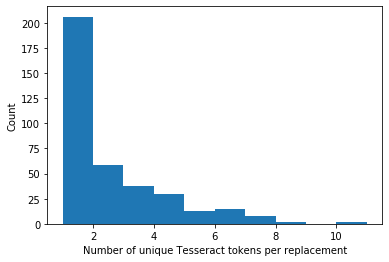

In [185]:
similar_frequency_df2 = similar_frequency_df.groupby("Guess", as_index = True).Tesseract.nunique()
# similar_frequency_df2
#similar_frequency_df2.mean()
plt.hist(similar_frequency_df2)
plt.xlabel("Number of unique Tesseract tokens per replacement")
plt.ylabel("Count")

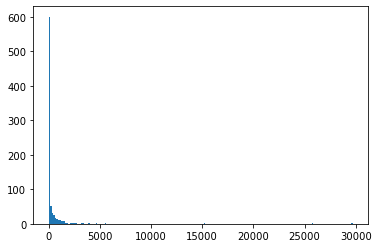

In [200]:
tesseract_frequency = similar_frequency_df.Tesseract.value_counts()
plt.hist(tesseract_frequency, 200)
#plt.show suppresses the annoying array printout
plt.show()

The scatter plot below plots number of unique Teseract tokens for each replacement token against the mean of the degree to which they are similar. The histogram above suggests that there are many 1:1 unique replacements. However, the degrees of similarities are very much clustered and show little variance as compared to the other replacement tokens. Suprisingly, the mean degree of similarity are rather *uniformly high*. 

Text(0, 0.5, 'Degree similarity (%)')

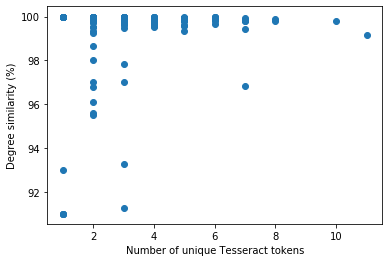

In [182]:
## agg fn allows insertion of functions or list of functions which are then returned as multindex cols
similar_frequency_df3 = similar_frequency_df.groupby("Guess", as_index = False).agg({
    "Tesseract": "nunique",
    "Similarity": "mean"
})
plt.scatter(similar_frequency_df3.Tesseract, similar_frequency_df3.Similarity)
plt.xlabel("Number of unique Tesseract tokens")
plt.ylabel("Degree similarity (%)")

In [179]:
similar_frequency_df3

,Guess,Tesseract,Similarity
0,10th,1,100.00
1,11th,1,100.00
2,12th,1,100.00
3,13th,1,100.00
4,14th,1,100.00
...,...,...,...
367,roof,1,100.00
368,store,1,91.00
369,the,1,100.00
370,under,3,93.25


In [155]:
similar_frequency_df.groupby("Tesseract").count()

,Guess,Similarity
Tesseract,,
10th,439,439
11th,1534,1534
12birmingham,1,1
12th,1698,1698
13th,1150,1150
...,...,...
wunder,2,2
xchange,8,8
york,82,82


As compared to the highly similar tokens and their replacements, the number of unique Tesseract tokens for each replacement token has increased dramatically. But at the same time, most Tesseract tokens occur at very low frequencies. That is to say, Tesseract's recognition and rendition of these tokens is inconsistent. This interpretation of the data implies that the master list against which this is compared is exhaustive and correct; as a result, if Tesseract is consistent, there should be less unique tokens, but they should occur more frequently.  
On the other hand, it might just be the case that the master list is *non-exhaustive* and does not capture the full variance of street names in NYC at the turn of the 20th century. In this case, the questions becomes, "How can Tesseract's output be verified?" 

Text(0, 0.5, 'Count')

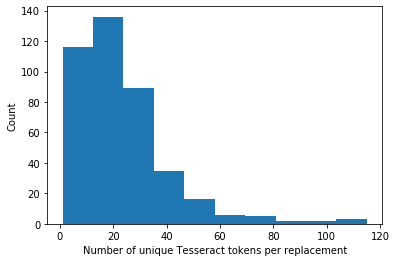

In [203]:
dissimilar_frequency_df2 = dissimilar_frequency_df.groupby("Guess", as_index = True).Tesseract.nunique()
#dissimilar_frequency_df2
#dissimilar_frequency_df2.mean()
plt.hist(dissimilar_frequency_df2)
plt.xlabel("Number of unique Tesseract tokens per replacement")
plt.ylabel("Count")

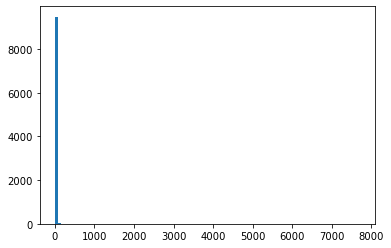

In [205]:
tesseract_frequency_dissimilar = dissimilar_frequency_df.Tesseract.value_counts()
plt.hist(tesseract_frequency_dissimilar, 100)
#plt.show suppresses the annoying array printout
plt.show()

Text(0, 0.5, 'Degree similarity (%)')

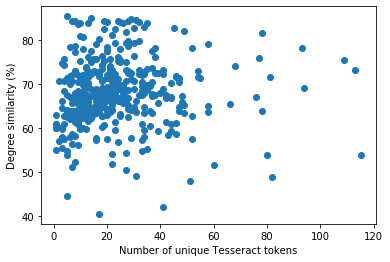

In [206]:
## agg fn allows insertion of functions or list of functions which are then returned as multindex cols
dissimilar_frequency_df3 = dissimilar_frequency_df.groupby("Guess", as_index = False).agg({
    "Tesseract": "nunique",
    "Similarity": "mean"
})
plt.scatter(dissimilar_frequency_df3.Tesseract, dissimilar_frequency_df3.Similarity)
plt.xlabel("Number of unique Tesseract tokens")
plt.ylabel("Degree similarity (%)")

In [156]:
dissimilar_frequency_df.groupby("Tesseract").count()

,Guess,Similarity
Tesseract,,
02d,1,1
04th,1,1
0o,1,1
0s,2,2
0th,5,5
...,...,...
zwi,1,1
zz,1,1
zéth,1,1


In [157]:
word_frequency_df.groupby("Tesseract")["Guess"].count()

Tesseract
16th         2
17th         2
24th         1
26th         1
32d          1
40th         2
41st         1
42d          1
a            1
av           6
ay           1
baxter       1
beach        1
beekman      1
bible        1
bway         4
catharine    1
centre       1
chariton     1
division     1
e            2
fi           1
fifth        1
front        2
georges      1
h19          1
highth       1
ichi         1
j            2
ja           1
james        1
john         2
mulberry     1
n            1
ninth        1
oe           1
orchard      2
second       2
stopher      1
suffolk      1
thomas       1
w            6
walker       1
wall         1
Name: Guess, dtype: int64

In [57]:
locations_tsv_trunc_2

# Issues and errors examples:
## False negatives: bway -> broadway, 67% similar 
## False positives: 127th -> 12th, 89% similar
## True positives: grand -> Grand, 100% similar
## True negatives: 68d -> dry, 33% similar | pl -> Pell, 67% similar

,directory_uuid,page_uuid,entry_uuid,location_count,offset_count,token,token_re,token_matched,pct_similarity
516890,4b119360-317a-0134-9131-00505686a51c,324.56767280.42990c50-5361-0134-af65-00505686a51c,87632a304cdc11eaba67821070c5d000,1,2,av.,av,"[Av, 100]",100.0
314224,4b119360-317a-0134-9131-00505686a51c,753.56767709.88d47570-5361-0134-38cb-00505686a51c,8a3565624cdb11eaba67821070c5d000,0,1,Walker,walker,"[Walker, 100]",100.0
374638,4b119360-317a-0134-9131-00505686a51c,807.56767763.8ddcc760-5361-0134-19f4-00505686a51c,d56633f44cdb11eaba67821070c5d000,0,0,175,175,175,NaN
209898,4b119360-317a-0134-9131-00505686a51c,495.56767451.51f57f70-5361-0134-06d3-00505686a51c,08b519924cdb11eaba67821070c5d000,0,0,227,227,227,NaN
24063,4b119360-317a-0134-9131-00505686a51c,968.56767924.9c85c870-5361-0134-ed06-00505686a51c,2494c6404cda11eaba67821070c5d000,0,0,71,71,71,NaN
...,...,...,...,...,...,...,...,...,...
55608,4b119360-317a-0134-9131-00505686a51c,581.56767537.79185120-5361-0134-c5b0-00505686a51c,4bbfba224cda11eaba67821070c5d000,0,1,Division,division,"[Division, 100]",100.0
222959,4b119360-317a-0134-9131-00505686a51c,225.56767181.39bcebf0-5361-0134-159b-00505686a51c,19055f1e4cdb11eaba67821070c5d000,0,1,W.,w,"[W, 100]",100.0
277149,4b119360-317a-0134-9131-00505686a51c,272.56767228.3e108dc0-5361-0134-8674-00505686a51c,5c53911e4cdb11eaba67821070c5d000,0,2,av.,av,"[Av, 100]",100.0
459441,4b119360-317a-0134-9131-00505686a51c,1074.56768030.8929db10-5362-0134-28d2-00505686...,3fd541a84cdc11eaba67821070c5d000,0,1,W.,w,"[W, 100]",100.0


In [92]:
print(occupations_tsv.entry_uuid.nunique())
occupations_tsv.head(n = 20)

151343


,directory_uuid,page_uuid,entry_uuid,occupation_count,offset_count,token
0,4b119360-317a-0134-9131-00505686a51c,720.56767676.85dd7cc0-5361-0134-726e-00505686a51c,076eb3324cda11eaba67821070c5d000,0,0,mings
1,4b119360-317a-0134-9131-00505686a51c,720.56767676.85dd7cc0-5361-0134-726e-00505686a51c,076eb5d04cda11eaba67821070c5d000,0,0,meat
2,4b119360-317a-0134-9131-00505686a51c,720.56767676.85dd7cc0-5361-0134-726e-00505686a51c,076eb6844cda11eaba67821070c5d000,0,0,tailor
3,4b119360-317a-0134-9131-00505686a51c,720.56767676.85dd7cc0-5361-0134-726e-00505686a51c,076eb7244cda11eaba67821070c5d000,0,0,wid.
4,4b119360-317a-0134-9131-00505686a51c,720.56767676.85dd7cc0-5361-0134-726e-00505686a51c,076eb7244cda11eaba67821070c5d000,0,1,Michael
5,4b119360-317a-0134-9131-00505686a51c,720.56767676.85dd7cc0-5361-0134-726e-00505686a51c,076eb7b04cda11eaba67821070c5d000,0,0,shoemkr
6,4b119360-317a-0134-9131-00505686a51c,720.56767676.85dd7cc0-5361-0134-726e-00505686a51c,076eb83c4cda11eaba67821070c5d000,0,0,u.
7,4b119360-317a-0134-9131-00505686a51c,720.56767676.85dd7cc0-5361-0134-726e-00505686a51c,076eb83c4cda11eaba67821070c5d000,0,1,s
8,4b119360-317a-0134-9131-00505686a51c,720.56767676.85dd7cc0-5361-0134-726e-00505686a51c,076eb8e64cda11eaba67821070c5d000,0,0,tailor
9,4b119360-317a-0134-9131-00505686a51c,720.56767676.85dd7cc0-5361-0134-726e-00505686a51c,076eb9684cda11eaba67821070c5d000,0,0,carpenter


Some pre-processing here:  
1) Removed punctuation

In [291]:
# function remove punctuation; converts plural to singular; removing single-lettered entries; remove names; remove completely capitalized nouns 
def clean_token(token):
    token = str(token)
    # check for names
    title_case = token.istitle()
    if title_case is True:
        token = ""
        return token
    else:
        # check and correct for punctuation
        token = ''.join(t for t in token if t.isalnum())
        # check for numbers
        numeral = token.isdigit()
        if numeral is True:
            token = ""
            return token
        # remove single entries
        if len(token) == 1: 
            token = ""
            return token
        # remove completely capitalized words because they might be from adverts
        caps = token.isupper()
        if caps is True:
            token = ""
            return token
        # check and stems plural nouns
        elif token.endswith("s"):
            token = token.rstrip("s")
            return token
        else:
            return token

# apply to column and create new column
occupations_tsv_working_copy = occupations_tsv
occupations_tsv_working_copy["token_re"] = occupations_tsv_working_copy["token"].apply(clean_token)

# drop rows with just whitespace
occupations_tsv_working_copy = occupations_tsv_working_copy.drop(occupations_tsv_working_copy[(occupations_tsv_working_copy.token_re == '')].index)

occupations_freq = occupations_tsv_working_copy["token_re"].value_counts()

In [297]:
occupations_freq.head(n = 60)

wid           13426
laborer        9509
tailor         5689
clerk          5115
mer            4065
carpenter      3768
grocer         3670
liquor         3375
broker         2635
carman         2569
lawyer         2436
smith          2408
butcher        2408
shoemkr        2382
seaman         1810
painter        1715
baker          1590
machinist      1559
porter         1544
agent          1364
imp            1349
segar          1320
mason          1279
driver         1272
police         1225
shoe           1216
cabinetmkr     1173
physician      1113
printer        1093
saloon         1081
produce        1035
drygd          1020
washing        1018
segarmkr       1003
mkt             976
bdgh            958
pre             880
cooper          839
pedlar          823
clothing        822
barber          815
jeweler         814
dressmkr        729
engineer        702
drug            683
fancygd         683
waiter          640
banker          609
plumber         579
hat             578


In [292]:
occupations_freq.shape

(6940,)

Assuming that Tesseract makes text recognition errors systematically and randomly, it can therefore be expected that variations of the same word is scattered throughout the dataset. Hence, less frequently occuring words can be matched to more frequently occurring one repeatedly until it coalesces to a more "correct" list. 

In [329]:
occupations_freq_df = pd.DataFrame(occupations_tsv_working_copy.groupby("token_re", as_index = False)["token"].count()).sort_values(by = "token",
                                                                                                                                   ascending = False).reset_index(drop = True)

In [330]:
occupations_freq_df

,token_re,token
0,wid,13426
1,laborer,9509
2,tailor,5689
3,clerk,5115
4,mer,4065
...,...,...
6935,guii,1
6936,guase,1
6937,guano,1
6938,érocer,1


In [ ]:
print(subjects_tsv.entry_uuid.nunique())
subjects_tsv.head(n = 20)

## Discarded | Obsolete Code

Initially, I thought that we might be able to correct some of the spelling errors presented by Tesseract. To test this, I applied this to a sample of occupations given that occupations are more likely to be found in a proper English dictionary than street and human names. However, the results are extremely poor due to the abbrieviations and Tesseract-errors. Furthermore, some words such as `segars` are the antiquated form of modern words such as `cigars` which the module does not pick up on. Instead, it suggests `sugars`, which is not technically wrong from a word-matching and spell-check standpoint. 

In [249]:
# https://www.clips.uantwerpen.be/pages/pattern-en#spelling
# https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html
# https://www.nltk.org/

""""
from pattern.en import suggest

#occupations sample
occupations_sample = occupations_freq_res.loc[:, ["original"]].sample(n = 100)
occupations_freq_res = occupations_freq.reset_index()
occupations_freq_res = occupations_freq_res.rename(columns = {"index": "original"})
occupations_freq_res = occupations_freq_res.astype({"original": str})

# spellcheck function with suggest
def spellcheck(token):
    digit_check = token.isdigit()
    if digit_check is True:
        return token
    else:
        checked = suggest(token)
        return checked
    
# Apply to sample
occupations_sample["corrected"] = occupations_sample["original"].apply(spellcheck)

# Glimpse into result
occupations_sample.head(n = 60)
""""

[Link](https://stackoverflow.com/questions/40712178/reading-the-json-file-with-multiple-objects-in-python) to help with decoding this particular JSON object. Multiple JSON object within one.

In [ ]:
# Opens the file and saves it to a pandas df
##with open(path + test_json) as f:
##    df = pd.read_json(f, lines=True)

In [ ]:
# Quick look into the JSON table to check
##df.tail()

In [ ]:
# Manual uniqueness check
##line_number = np.array(df.original_hocr_line_number)
##unique_elements, counts_elements = np.unique(line_number, return_counts=True)
##print("Frequency of unique values of the said array:")
##print(np.asarray((unique_elements, counts_elements)))

Labels "a", "h", and "r" represent the relative addresses, and address types such as houses, and rear.

In [ ]:
# Quick glimpse of how the last column might actually look like
## df.iloc[124,-1]

In [ ]:
##df.iloc[110,-1]

In [ ]:
##df.iloc[10,-1]

In [ ]:
##df.iloc[4,-1]

In [ ]:
##df.iloc[147, -1]

In [ ]:
##df_labeled_entry = df.labeled_entry.apply(pd.Series)
##df_locations = df_labeled_entry["locations"]
##df_locations = pd.concat([df_locations, df.original_hocr_line_number], axis = 1)

In [ ]:
##df_locations

In [ ]:
##df_locations.iloc[147,:]

In [ ]:
##type(df_locations.iloc[147,0])

In [ ]:
##type(df_locations.iloc[147,0][1])

In [ ]:
##df_locations.iloc[147][0]

In other words, each labeled entry's location is stored as a list of _n_ dictionaries with two key-value pairs of `value` and `labels`.

In [ ]:
##df_locations.iloc[3][0]

In [ ]:
##type(df_locations)

In [ ]:
# This checks for existence of labels, duly records the (non)existence, strips it out, appends to another list
# This is done w/o loss to order

#line_num_list = []
#complete_street_name = []
#split_street_name = []
#labels = []
#for entry in range(0,len(df_locations)):
#    #print(df_locations.iloc[entry])
#    for dicts in df_locations.iloc[entry][0]:
#        if 'labels' in dicts:
#            for key, value in dicts.items():
#                #line_num_list.append(df_locations.iloc[entry][1])
#                if key == 'labels':
#                    labels.append(value)
#                else:
#                    complete_street_name.append(value)
#                    street_name_split = str(value).split()
#                    split_street_name.append(street_name_split)
#                    line_num_list.append(df_locations.iloc[entry][1])
#        else:
#            for key, value in dicts.items():
#                line_num_list.append(df_locations.iloc[entry][1])
#                labels.append(" ")
#                complete_street_name.append(value)
#                street_name_split = str(value).split()
#                split_street_name.append(street_name_split)


It appears that avenues are spelled out and streets are enumerated.

In [ ]:
#split_street_name

In [ ]:
#unlisted_location = pd.concat([pd.Series(complete_street_name), pd.Series(split_street_name), pd.Series(labels), pd.Series(line_num_list)], axis = 1)
#unlisted_location.columns = ["complete_street_name", "split_street_name", "labels", "line_number"]

In [ ]:
#len(line_num_list)

In [ ]:
#unlisted_location

In [ ]:
# first order of business is to test if string is a street number
# if it is not, then it is probably a street name, and a comparison can be made
# Perform regex to remove the periods
# https://www.datacamp.com/community/tutorials/fuzzy-string-python
# https://datascience.stackexchange.com/questions/29775/how-to-check-and-correct-misspelling-in-the-data-of-pairs-of-words
# http://blog.keyrus.co.uk/fuzzy_matching_101_part_i.html
# http://blog.keyrus.co.uk/fuzzy_matching_101_part_ii.html

#for i in range(0, len(unlisted_location)):
#    non_numeric_street_name = []
#    for address_component in unlisted_location.iloc[i, 1]:
#        if address_component.isnumeric() == False:
#            non_numeric_street_name.append(address_component)
#            print(non_numeric_street_name)
#        unlisted_location.iloc[i]["non_numeric"] = non_numeric_street_name
            
#        #print(address_component.isnumeric())


In [ ]:
#unlisted_location